In [1]:
#  STEP 1: Import necessary libraries for recommendation system (KNN)

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#  STEP 2: Load and clean product metadata

# Load the product metadata
df = pd.read_csv("../data/product_info.csv")

# Select key features for similarity (we'll tune this list later if needed)
df = df[['product_id', 'product_name', 'brand_name', 'price_usd', 'primary_category']]

# Drop rows with missing values in any of the selected columns
df = df.dropna()

# Reset index after filtering
df = df.reset_index(drop=True)

# Preview cleaned dataset
df.head()


,product_id,product_name,brand_name,price_usd,primary_category
0,P473671,Fragrance Discovery Set,19-69,35.0,Fragrance
1,P473668,La Habana Eau de Parfum,19-69,195.0,Fragrance
2,P473662,Rainbow Bar Eau de Parfum,19-69,195.0,Fragrance
3,P473660,Kasbah Eau de Parfum,19-69,195.0,Fragrance
4,P473658,Purple Haze Eau de Parfum,19-69,195.0,Fragrance


In [3]:
# 🧠 STEP 3: Prepare product features for KNN similarity

# One-Hot Encode brand and category
ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_cat = ohe.fit_transform(df[['brand_name', 'primary_category']])

# Scale price for fair distance calculation
scaler = StandardScaler()
X_price = scaler.fit_transform(df[['price_usd']])

# Convert scaled price to sparse format to match other matrices
from scipy.sparse import csr_matrix, hstack
X_price_sparse = csr_matrix(X_price)

# Combine all features into one matrix
X_features = hstack([X_cat, X_price_sparse])

# Confirm shape
print("🔢 Feature matrix shape:", X_features.shape)


🔢 Feature matrix shape: (8494, 314)


In [5]:
# 🤖 STEP 4: Fit KNN model and create a recommendation function

# I use cosine distance (good for mixed sparse features)
knn = NearestNeighbors(n_neighbors=6, metric='cosine')  # 1 + 5 neighbors (1 = itself)
knn.fit(X_features)

# Helper function to recommend similar products
def recommend_similar_products(product_index, n=5):
    # Find nearest neighbors
    distances, indices = knn.kneighbors(X_features[product_index], n_neighbors=n+1)
    
    print(f"🔍 Products similar to: {df.iloc[product_index]['product_name']}\n")
    
    for i, idx in enumerate(indices[0][1:]):  # Skip the first (it's the product itself)
        name = df.iloc[idx]['product_name']
        brand = df.iloc[idx]['brand_name']
        price = df.iloc[idx]['price_usd']
        category = df.iloc[idx]['primary_category']
        print(f"{i+1}. {name} ({brand}) - ${price:.2f} | Category: {category}")


In [6]:
recommend_similar_products(product_index=100)


🔍 Products similar to: GENIUS Ultimate Anti-Aging Vitamin C+ Serum

1. GENIUS Liquid Collagen Serum (Algenist) - $115.00 | Category: Skincare
2. GENIUS Ultimate Anti-Aging Cream (Algenist) - $112.00 | Category: Skincare
3. GENIUS Sleeping Collagen Moisturizer (Algenist) - $98.00 | Category: Skincare
4. ELEVATE Advanced Retinol Serum (Algenist) - $98.00 | Category: Skincare
5. Algae Peptide Regenerative Moisturizer (Algenist) - $98.00 | Category: Skincare


In [7]:
# 🔍 STEP 5: Recommend similar products based on product name

def recommend_by_name(product_name, n=5):
    # Try to find the product index
    matches = df[df['product_name'].str.contains(product_name, case=False, na=False)]
    
    if matches.empty:
        print(f"❌ No product found matching '{product_name}'")
        return
    
    product_index = matches.index[0]
    
    print(f"🔍 Products similar to: {df.iloc[product_index]['product_name']}\n")
    
    # Use the same knn model to find neighbors
    distances, indices = knn.kneighbors(X_features[product_index], n_neighbors=n+1)
    
    for i, idx in enumerate(indices[0][1:]):
        name = df.iloc[idx]['product_name']
        brand = df.iloc[idx]['brand_name']
        price = df.iloc[idx]['price_usd']
        category = df.iloc[idx]['primary_category']
        print(f"{i+1}. {name} ({brand}) - ${price:.2f} | Category: {category}")


In [8]:
recommend_by_name("C+ Serum")


🔍 Products similar to: Charlotte’s Magic Serum with Vitamin C

1. Collagen Superfusion Firming & Plumping Facial Oil (Charlotte Tilbury) - $85.00 | Category: Skincare
2. Magic Cream Moisturizer with Hyaluronic Acid (Charlotte Tilbury) - $100.00 | Category: Skincare
3. Cryo-Recovery Depuffing Eye Serum (Charlotte Tilbury) - $70.00 | Category: Skincare
4. Charlotte’s Magic Eye Cream with Retinol (Charlotte Tilbury) - $65.00 | Category: Skincare
5. Multi-Miracle Glow Cleansing Balm (Charlotte Tilbury) - $60.00 | Category: Skincare


C:\Users\KORISNIK\AppData\Local\Temp\ipykernel_2548\4233547790.py:17: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KORISNIK\Desktop\sephora-ml-project\venv310\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


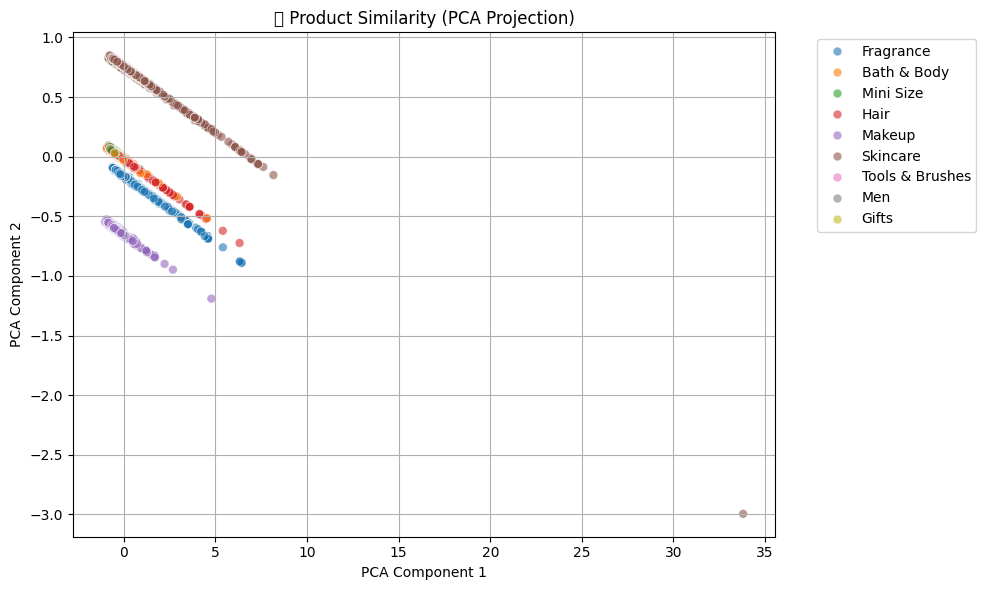

In [9]:
# 📊 STEP 6: Visualize product similarity using PCA

from sklearn.decomposition import PCA

# Reduce to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_features.toarray())

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=df['primary_category'], alpha=0.6, s=40, palette='tab10')
plt.title("🧭 Product Similarity (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
